In [1]:
!nvidia-smi

Sat Sep 30 09:57:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

- Encoder & decoder both gets one-hot vector with 0.5 each on index+1 & index +2

In [2]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import numpy as np
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [3]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
bs = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 234408962.61it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11081849.22it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 60743508.32it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18567766.83it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc40 = nn.Linear(x_dim, h_dim2)
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h0 = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h0))
        temp0 = self.fc31(h)
        temp1 = self.fc32(h)
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z, one_hot):
        h00 = F.relu(self.fc40(one_hot))
        h = F.relu(self.fc4(z))
        h = torch.add(h, h00)
        h = F.relu(self.fc5(h))
        h = F.sigmoid(self.fc6(h))
        return h

    def forward(self, x, one_hot):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z, one_hot.view(-1, 784)), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [ ]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc40): Linear(in_features=784, out_features=256, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [6]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [7]:
def train(epoch):
    vae.train()
    train_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, label) in enumerate(pbar):
        data = data.float().cuda()

        # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
        label_one_hot = F.one_hot(label, 10).float().cuda()
        indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
        zero_tensor = torch.zeros_like(data)
        for batch_num, index in enumerate(indices[1]):
            if index == 9:
                zero_tensor[batch_num, :, 0] = 0.5
                zero_tensor[batch_num, :, 1] = 0.5
            elif index == 8:
                zero_tensor[batch_num, :, 9] = 0.5
                zero_tensor[batch_num, :, 0] = 0.5
            else:
                zero_tensor[batch_num, :, index+1] = 0.5
                zero_tensor[batch_num, :, index+2] = 0.5
        zero_tensor = zero_tensor.float().cuda()
        new_data = torch.add(data, zero_tensor)

        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(new_data, zero_tensor)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        pbar.set_description(desc=f'Epoch = {epoch} Loss={loss.item()/len(data) :0.4f} Batch={batch_idx}')

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [8]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.float().cuda()

            # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
            label_one_hot = F.one_hot(label, 10).float().cuda()
            indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
            zero_tensor = torch.zeros_like(data)
            for batch_num, index in enumerate(indices[1]):
                if index == 9:
                    zero_tensor[batch_num, :, 0] = 0.5
                    zero_tensor[batch_num, :, 1] = 0.5
                elif index == 8:
                    zero_tensor[batch_num, :, 9] = 0.5
                    zero_tensor[batch_num, :, 0] = 0.5
                else:
                    zero_tensor[batch_num, :, index+1] = 0.5
                    zero_tensor[batch_num, :, index+2] = 0.5
            zero_tensor = zero_tensor.float().cuda()
            new_data = torch.add(data, zero_tensor)

            recon, mu, log_var = vae(new_data, zero_tensor)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====>     Test loss: {:.4f}'.format(test_loss))

In [9]:
for epoch in range(1, 61):
    train(epoch)
    test()

  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 166.0092
====>     Test loss: 141.7103


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 138.6738
====>     Test loss: 136.4669


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 135.1307
====>     Test loss: 134.1540


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 4 Average loss: 133.4486
====>     Test loss: 132.9542


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 5 Average loss: 132.4799
====>     Test loss: 132.3498


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 6 Average loss: 131.7077
====>     Test loss: 131.8084


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 7 Average loss: 131.1215
====>     Test loss: 131.2226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 8 Average loss: 130.6726
====>     Test loss: 131.1277


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 9 Average loss: 130.2486
====>     Test loss: 130.4133


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 10 Average loss: 129.8479
====>     Test loss: 130.1586


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 11 Average loss: 129.5539
====>     Test loss: 129.9234


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 12 Average loss: 129.2101
====>     Test loss: 129.6888


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 13 Average loss: 128.9329
====>     Test loss: 129.5094


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 14 Average loss: 128.7585
====>     Test loss: 129.2591


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 15 Average loss: 128.4964
====>     Test loss: 129.4144


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 16 Average loss: 128.2529
====>     Test loss: 128.9246


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 17 Average loss: 128.0631
====>     Test loss: 128.8435


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 18 Average loss: 127.8927
====>     Test loss: 128.9934


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 19 Average loss: 127.6405
====>     Test loss: 128.8276


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 20 Average loss: 127.4202
====>     Test loss: 128.4213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 21 Average loss: 127.2462
====>     Test loss: 128.6029


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 22 Average loss: 127.1268
====>     Test loss: 128.4100


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 23 Average loss: 126.8861
====>     Test loss: 128.2842


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 24 Average loss: 126.8051
====>     Test loss: 128.4098


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 25 Average loss: 126.6866
====>     Test loss: 128.3520


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 26 Average loss: 126.4549
====>     Test loss: 128.1995


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 27 Average loss: 126.3001
====>     Test loss: 128.2510


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 28 Average loss: 126.2126
====>     Test loss: 127.7832


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 29 Average loss: 126.0045
====>     Test loss: 128.0027


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 30 Average loss: 125.8559
====>     Test loss: 127.8466


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 31 Average loss: 125.7301
====>     Test loss: 127.6705


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 32 Average loss: 125.5764
====>     Test loss: 127.7908


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 33 Average loss: 125.4276
====>     Test loss: 127.4757


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 34 Average loss: 125.3290
====>     Test loss: 127.4835


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 35 Average loss: 125.2129
====>     Test loss: 127.4959


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 36 Average loss: 125.1030
====>     Test loss: 127.3639


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 37 Average loss: 124.9587
====>     Test loss: 127.3487


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 38 Average loss: 124.8911
====>     Test loss: 127.1948


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 39 Average loss: 124.7718
====>     Test loss: 127.3089


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 40 Average loss: 124.7973
====>     Test loss: 127.4306


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 41 Average loss: 124.6092
====>     Test loss: 127.1330


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 42 Average loss: 124.4980
====>     Test loss: 127.1323


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 43 Average loss: 124.3870
====>     Test loss: 126.9099


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 44 Average loss: 124.2851
====>     Test loss: 127.1932


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 45 Average loss: 124.2388
====>     Test loss: 127.2078


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 46 Average loss: 124.1101
====>     Test loss: 127.0231


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 47 Average loss: 123.9897
====>     Test loss: 126.9160


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 48 Average loss: 123.9033
====>     Test loss: 127.0117


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 49 Average loss: 123.9440
====>     Test loss: 127.0109


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 50 Average loss: 123.7594
====>     Test loss: 127.0442


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 51 Average loss: 123.7320
====>     Test loss: 126.9814


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 52 Average loss: 123.6562
====>     Test loss: 126.8352


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 53 Average loss: 123.7010
====>     Test loss: 126.8552


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 54 Average loss: 123.5381
====>     Test loss: 126.7927


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 55 Average loss: 123.4616
====>     Test loss: 126.9540


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 56 Average loss: 123.3590
====>     Test loss: 126.9457


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 57 Average loss: 123.3251
====>     Test loss: 126.7580


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 58 Average loss: 123.2445
====>     Test loss: 126.7904


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 59 Average loss: 123.1738
====>     Test loss: 126.5962


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 60 Average loss: 123.1495
====>     Test loss: 126.7234


In [10]:
!mkdir './samples'

In [11]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    o = torch.randn(64, 1, 28, 28).cuda()
    o1 = o.view(-1, 784)
    sample = vae.decoder(z, o1).cuda()

    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

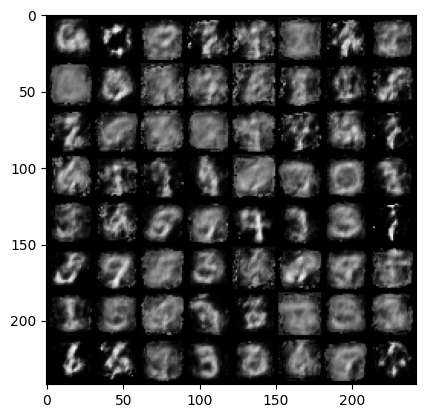

In [12]:
img = plt.imread('/content/samples/sample_.png')
plt.imshow(img)

In [13]:
def validate():
    vae.eval()
    with torch.no_grad():
        i = 0
        for data, label in val_loader:
            i += 1
            if i > 0:
                break

        print(f' Correct   label : {label.tolist()}')
        data = data.float().cuda()

        # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
        label_one_hot = F.one_hot(label, 10).float().cuda()
        indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
        zero_tensor = torch.zeros_like(data)
        for batch_num, index in enumerate(indices[1]):
            if index == 9:
                zero_tensor[batch_num, :, 0] = 0.5
                zero_tensor[batch_num, :, 1] = 0.5
            elif index == 8:
                zero_tensor[batch_num, :, 9] = 0.5
                zero_tensor[batch_num, :, 0] = 0.5
            else:
                zero_tensor[batch_num, :, index+1] = 0.5
                zero_tensor[batch_num, :, index+2] = 0.5
        zero_tensor = zero_tensor.float().cuda()
        new_data = torch.add(data, zero_tensor)

        recon_val, mu_val, log_var_val = vae(new_data, zero_tensor)

        save_image(data, './samples/data_32' + '.png')
        save_image(recon_val.view(32, 1, 28, 28), './samples/pred_32_with_correct_label' + '.png')

        for lab in label:
            if lab == 9:
                lab -= 9
            else:
                lab += 1

        print(f' Modified  label : {label.tolist()}')

        # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
        label_one_hot = F.one_hot(label, 10).float().cuda()
        indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
        zero_tensor = torch.zeros_like(data)
        for batch_num, index in enumerate(indices[1]):
            if index == 9:
                zero_tensor[batch_num, :, 0] = 0.5
                zero_tensor[batch_num, :, 1] = 0.5
            elif index == 8:
                zero_tensor[batch_num, :, 9] = 0.5
                zero_tensor[batch_num, :, 0] = 0.5
            else:
                zero_tensor[batch_num, :, index+1] = 0.5
                zero_tensor[batch_num, :, index+2] = 0.5
        zero_tensor = zero_tensor.float().cuda()
        new_data = torch.add(data, zero_tensor)

        recon_val_wrong, mu_val, log_var_val = vae(new_data, zero_tensor)
        save_image(recon_val_wrong.view(32, 1, 28, 28), './samples/pred_32_with_wrong_label' + '.png')

        input_arr   = np.asarray(Image.open('/content/samples/data_32.png'))
        correct_arr = np.asarray(Image.open('/content/samples/pred_32_with_correct_label.png'))
        wrong_arr   = np.asarray(Image.open('/content/samples/pred_32_with_wrong_label.png'))
        np_arr = np.stack((input_arr, correct_arr, wrong_arr))
        title_list = ['Original Input', 'Pred with correct labels', 'Pred with modified labels']

        plt.figure(figsize=(12, 12))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.imshow(np_arr[i])
            plt.title(title_list[i])
            plt.axis('off')
        plt.show()

 Correct   label : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1]
 Modified  label : [8, 3, 2, 1, 5, 2, 5, 0, 6, 0, 1, 7, 0, 1, 2, 6, 0, 8, 4, 5, 0, 7, 7, 6, 5, 1, 8, 5, 1, 2, 4, 2]


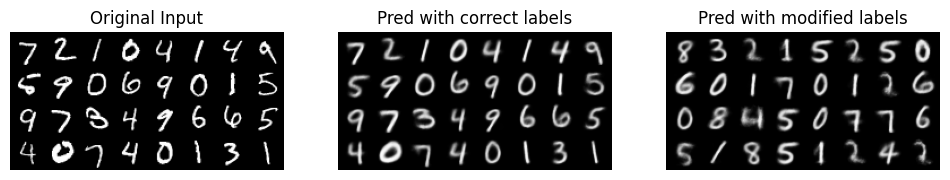

In [14]:
validate()

#### # One-hot Label logic sample check

In [ ]:
# One-hot Label logic sample check


prev_tensor = torch.ones(2, 10, 10)
zero_tensor = torch.zeros(2, 10, 10)

labels_list = [9, 6]
labels = torch.tensor(labels_list)
print(f'labels : {labels}')
label_one_hot = F.one_hot(labels, 10)
print(f'label_one_hot : {label_one_hot}')

indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
print(f' indices are {indices}')
# zero_tensor[:, index] = 0.5
# zero_tensor[:, index+1] = 0.5

for batch_idx, idx in enumerate(indices[1]):
    print(batch_idx, idx)
    zero_tensor[batch_idx, :, idx] = 0.7
    if idx == 9:
        zero_tensor[batch_idx, :, 0] = 0.3
    else:
        zero_tensor[batch_idx, :, idx+1] = 0.3

new_tensor = torch.add(prev_tensor, zero_tensor)
print(f'zero_tensor: {zero_tensor}')
print(f'new_tensor: {new_tensor}')
print(f'new_tensor.shape: {new_tensor.shape}')

labels : tensor([9, 6])
label_one_hot : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
 indices are (tensor([0, 1]), tensor([9, 6]))
0 tensor(9)
1 tensor(6)
zero_tensor: tensor([[[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.000